# Data loading

[ Info: reading /scratch/ns59/HiQGA.jl/ASEG_Hobart_Workshop_2024/UDF_data/twolines.dat
[ Info: reading /scratch/ns59/HiQGA.jl/ASEG_Hobart_Workshop_2024/UDF_data/electronics_halt.jl
[ Info: read 3 out of 26
[ Info: read 6 out of 26
[ Info: read 9 out of 26
[ Info: read 12 out of 26
[ Info: read 15 out of 26
[ Info: read 18 out of 26
[ Info: read 21 out of 26
[ Info: read 24 out of 26


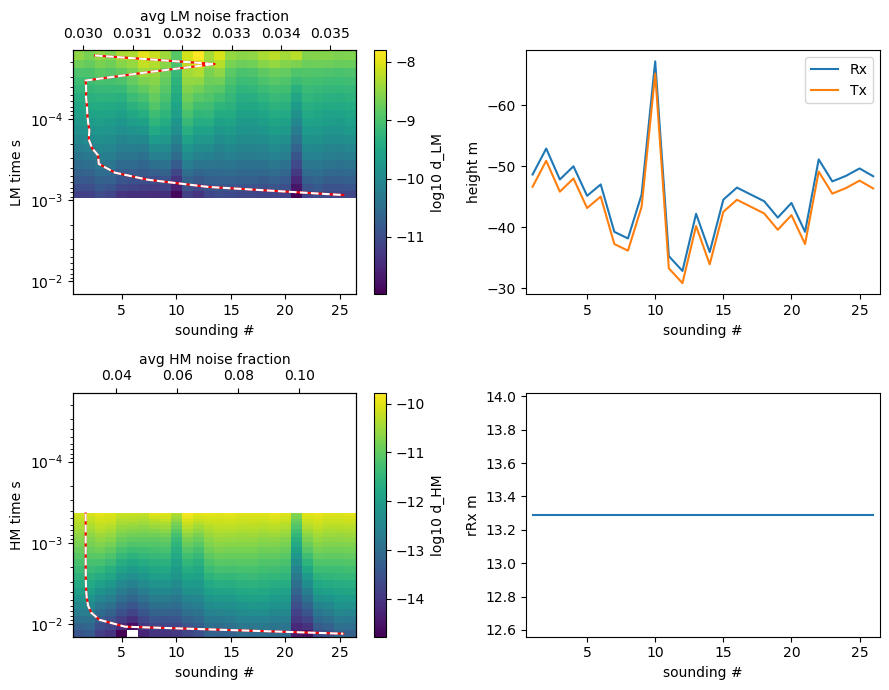

In [1]:
# info to read data
using HiQGA
# datafile
fname_dat = "/scratch/ns59/HiQGA.jl/ASEG_Hobart_Workshop_2024/UDF_data/twolines.dat"
# electronics file
fname_specs_halt = "/scratch/ns59/HiQGA.jl/ASEG_Hobart_Workshop_2024/UDF_data/electronics_halt.jl"
# column numbers from hdr file
X, Y, Z = 1, 2, 3
fid = 73
linenum = 72
frame_height = 4
frame_dx = 5
frame_dy = 6
frame_dz = 7
LM_Z = [16, 33]
HM_Z = [49, 71]
relerror = false
units = 1e-12
# load the data
include(fname_specs_halt)
soundings = transD_GP.SkyTEM1DInversion.read_survey_files(;fname_dat = fname_dat,
								lowpassfcs, LM_times, HM_times, LM_ramp, HM_ramp, 
								LM_noise, HM_noise, rTx,
								LM_Z             = LM_Z,
								HM_Z             = HM_Z,
								frame_height     = frame_height,
								frame_dz         = frame_dz,
								frame_dy         = frame_dy,
								frame_dx         = frame_dx,
								X                = X,
								Y                = Y,
								Z                = Z,
								fid              = fid,
								units            = units,
								relerror         = relerror,
								linenum          = linenum,
								startfrom        = 1,
								skipevery        = 100,
								dotillsounding   = nothing,
								makeqcplots      = true);

# Occam's inversion

In [2]:
# make gradient inversion options same for all soundings
σstart, σ0         = -2, -2
zfixed             = [-1e5]
ρfixed             = [1e12]
zstart             = 0.0
extendfrac         = 1.06
dz                 = 1.5
ρbg                = 10
nlayers            = 50
modelprimary       = false
regtype            = :R1
nstepsmax          = 40
ntries             = 10
target             = nothing
lo                 = -3. # log 10 S/m
hi                 = 1.  # log 10 S/m
λ²min              = -0.5
λ²max              = 8
λ²frac             = 4
β²                 = 0.1
knownvalue         = 0.7
breakonknown       = true
zipsaveprefix      = "UDF_subsampled_β²_$(β²)_$(regtype)_bg_$(round(10. ^σ0, sigdigits=4))_Spm"
isfile(zipsaveprefix*"_zipped.dat") && rm(zipsaveprefix*"_zipped.dat") # delete previous run
# to help with next part
using Random; Random.seed!(15)

TaskLocalRNG()

# Sanity check with only one sounding

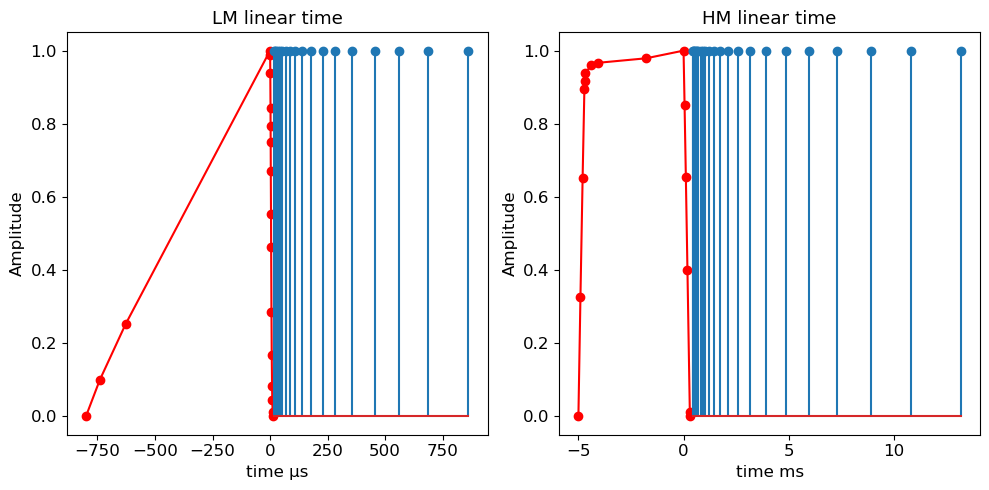

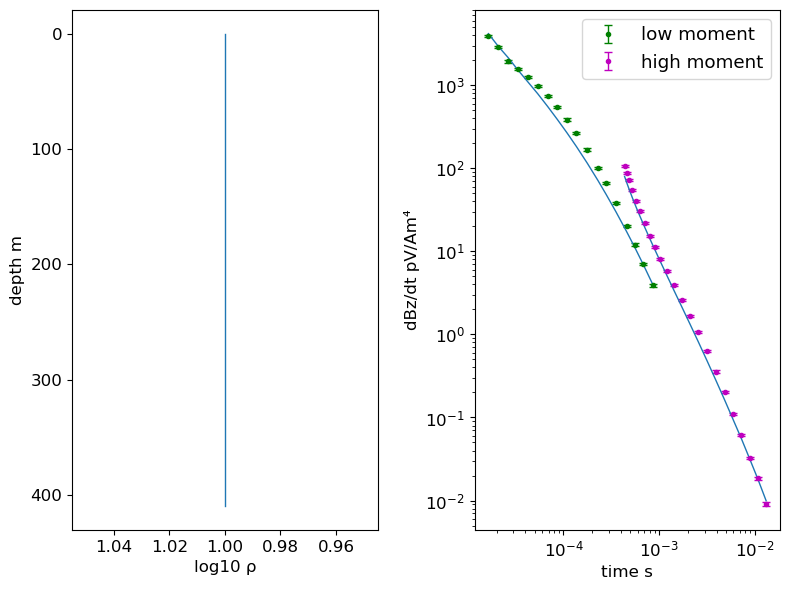

In [3]:
# Plot a random sounding and a background response
aem, zall, = transD_GP.SkyTEM1DInversion.makeoperator(
    soundings[rand(1:length(soundings))];
    zfixed, ρfixed, zstart, extendfrac, calcjacobian=true,
    dz, ρbg, nlayers, plotfield=true);

invert only one sounding to see if settings make sense

[ Info: iteration: 1 χ²: 9764.243021106111 target: 41
[ Info: iteration: 2 χ²: 2837.9240605320088 target: 41
[ Info: iteration: 3 χ²: 1040.2029290962744 target: 41
[ Info: iteration: 4 χ²: 600.9874324174992 target: 41
[ Info: iteration: 5 χ²: 96.17405690958188 target: 41
[ Info: iteration: 6 χ²: 41.000000000001876 target: 41


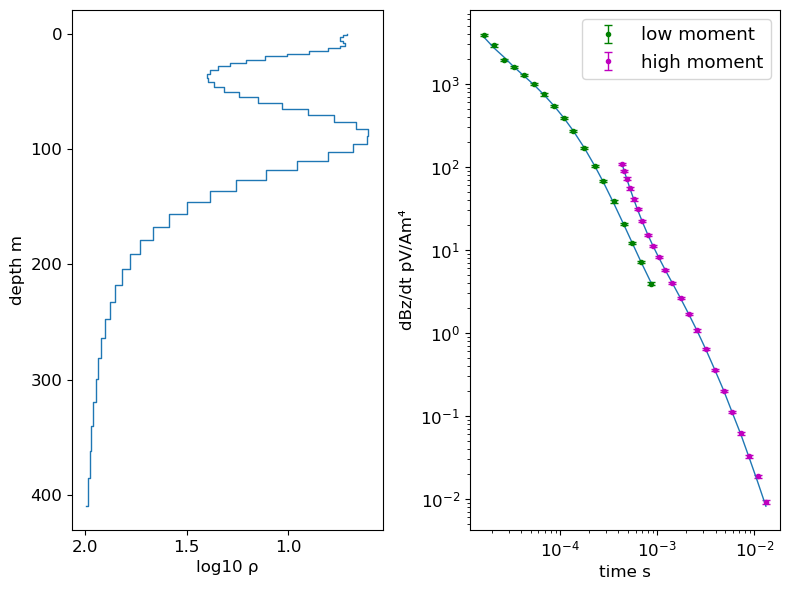

(true, true)

In [4]:
con_start, con_ref = map(x->x*ones(length(aem.ρ)-aem.nfixed), [σstart, σ0])
m, χ², λ², idx = transD_GP.gradientinv(con_start, con_ref, aem; nstepsmax=20,
                            λ²min, λ²max, β², ntries, knownvalue,
                            lo, hi, regtype);
mlast = -m[end][idx[end]] #get last model and convert to log10 resistivity
transD_GP.plotmodelfield!(aem, mlast)
# make sure Jacobian calculation is switched on after test inversion
aem.Flow.calcjacobian, aem.Fhigh.calcjacobian = true, true

# Parallel initialisation

In [5]:
# split into sequential iterations of parallel soundings
using Distributed
nsoundings = length(soundings)
nprocs() > 1 && rmprocs(workers()) # if any workers existed from earlier runs
addprocs(6) # Make sure you have at least 7 CPUs!
ncores = nworkers()
@info "there are $ncores workers"
nsequentialiters = ceil(Int, nsoundings/ncores)
@info "will require $nsequentialiters iterations of $ncores soundings"
# set up HiQGA on all workers
@everywhere using Distributed
@everywhere using HiQGA.transD_GP

[ Info: there are 6 workers
[ Info: will require 5 iterations of 6 soundings


# Do the soundings in parallel

In [6]:
@info "starting"
transD_GP.loopacrossAEMsoundings(soundings, aem, σstart, σ0; verbose=true, minimprovfrac=0.001,
                            nsequentialiters, regtype, nstepsmax, ntries,
                            lo, hi, λ²min, λ²max, β², knownvalue, breakonknown,
                            zipsaveprefix)
rmprocs(workers())

[ Info: starting


      From worker 3:	[ Info: sounding_100401_4.73528695e7_gradientinv.dat : iteration: 1 χ²: 21945.325277911397 target: 41
      From worker 4:	[ Info: sounding_100401_4.73529195e7_gradientinv.dat : iteration: 1 χ²: 22146.99363059755 target: 41
      From worker 6:	[ Info: sounding_100401_4.73530195e7_gradientinv.dat : iteration: 1 χ²: 6175.515285728411 target: 41
      From worker 7:	[ Info: sounding_100401_4.73530695e7_gradientinv.dat : iteration: 1 χ²: 3046.195090196396 target: 41
      From worker 2:	[ Info: sounding_100401_4.73528195e7_gradientinv.dat : iteration: 1 χ²: 20800.222315323335 target: 41
      From worker 5:	[ Info: sounding_100401_4.73529695e7_gradientinv.dat : iteration: 1 χ²: 19239.13923037994 target: 41
      From worker 3:	[ Info: sounding_100401_4.73528695e7_gradientinv.dat : iteration: 2 χ²: 5745.2627752912285 target: 41
      From worker 6:	[ Info: sounding_100401_4.73530195e7_gradientinv.dat : iteration: 2 χ²: 2121.8344725841453 target: 41
      From worker 4:

Task (done) @0x0000146f220bebd0

# Plot the results

idspec = idx[doesmatch] = [5, 15]


[ Info: 100401
[ Info: X, Y = 152860.23, 6.47670807e6
[ Info: X, Y = 144419.37, 6.48876654e6
[ Info: ϕd is 1.0
[ Info: ϕd is 4.687


idspec = idx[doesmatch] = [3]


[ Info: 100502
[ Info: X, Y = 156548.71, 6.4801282e6
[ Info: ϕd is 1.0


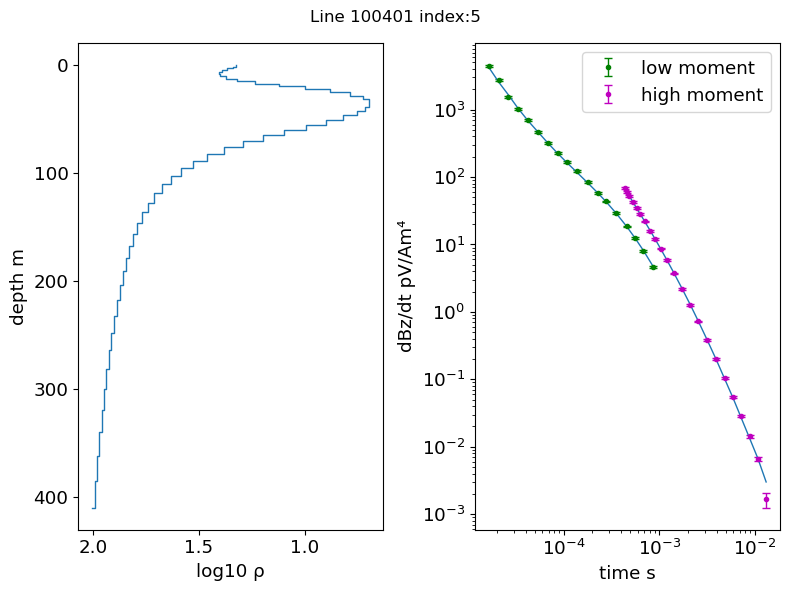

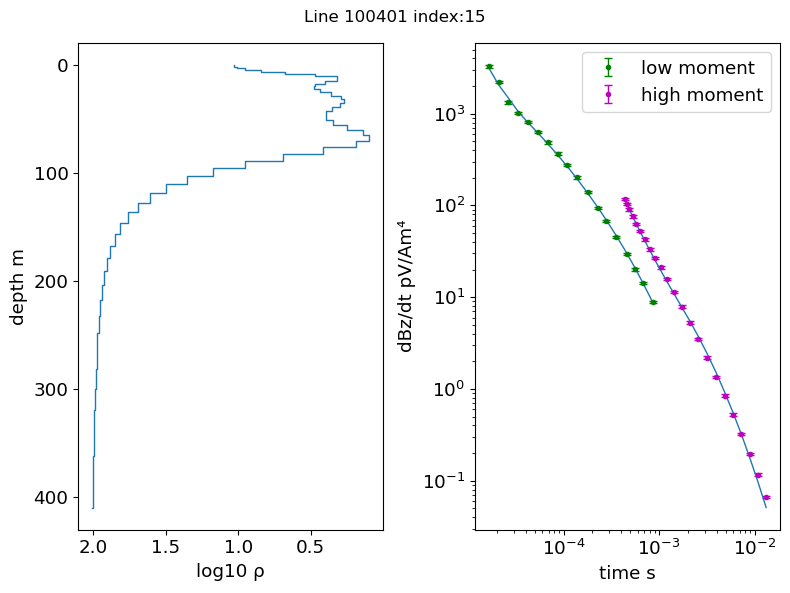

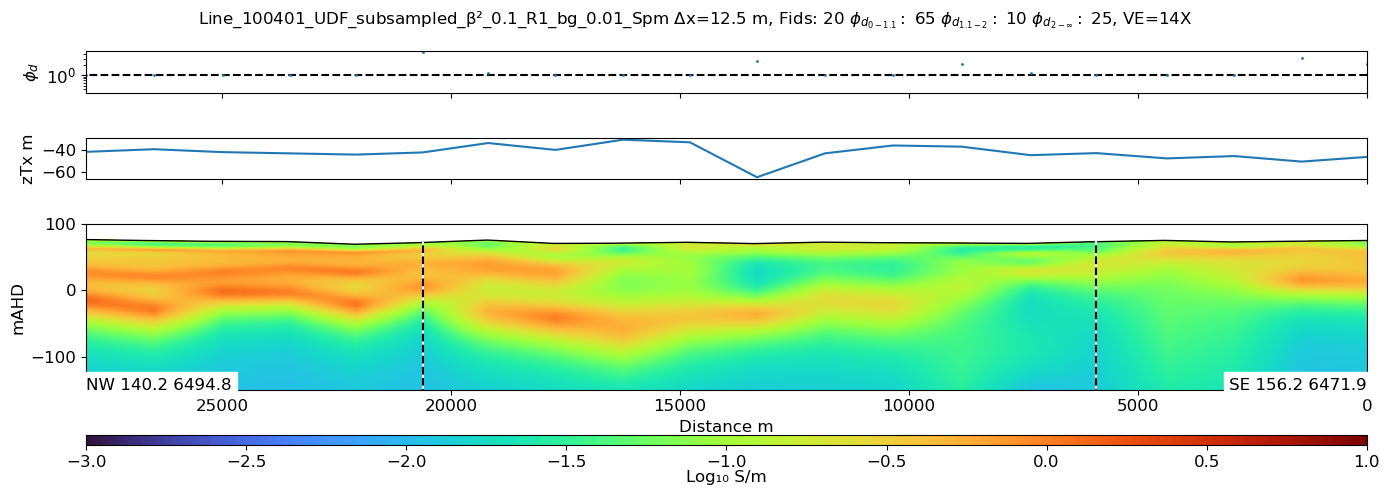

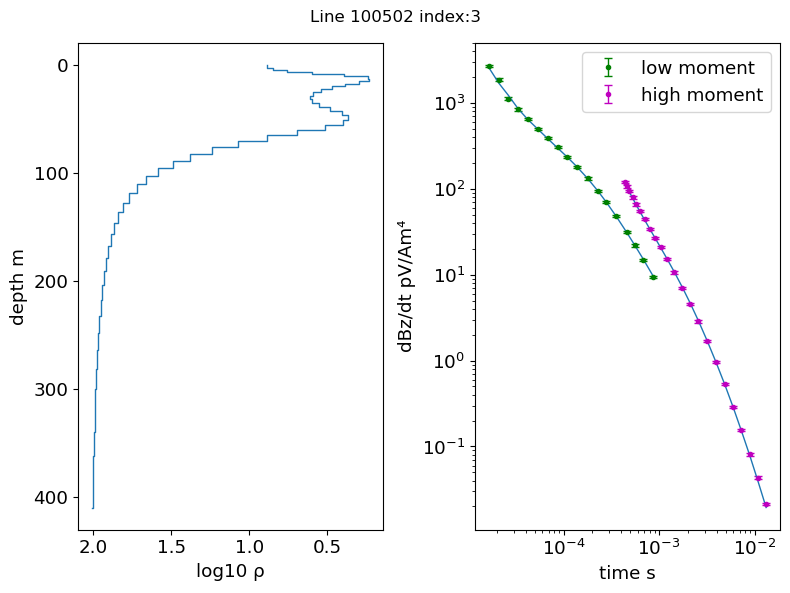

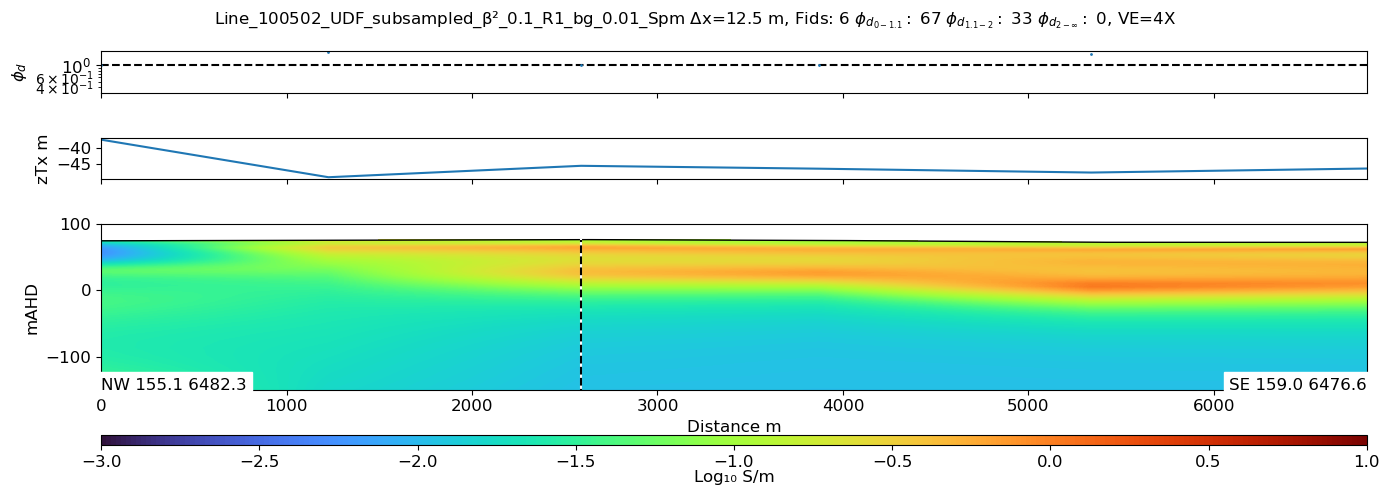

In [7]:
# lines to plot
lnames = [100401, 100502]
# sounding index to plot per line
idx = [[5, 15],[3]]
# interpolation spacing
dr = 12.5
# do it
transD_GP.plotconvandlast(soundings, dr, dz; zall, lnames, idx,
  plotforward=true, aem_in=aem, prefix=zipsaveprefix,
  figsize=(14,5), vmin=lo, vmax=hi, postfix=zipsaveprefix, yl=[-150, 100],
  preferEright=true, showplot=true, logscale=true, saveplot=true)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*